In [1]:
# ==============================================================================
# CELL 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU (v6.7 - Tăng cường độ bền)
# ==============================================================================
import os
import json
import asyncio
import operator
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

# --- KHỞI TẠO LLM ---
try:
    # === NÂNG CẤP V6.7: THÊM CƠ CHẾ TỰ ĐỘNG THỬ LẠI ===
    # Thêm max_retries=2 để tự động thử lại 2 lần nếu gặp lỗi server (như lỗi 503)
    llm = ChatGroq(
        temperature=0.1, model="llama3-70b-8192",
        api_key=os.getenv("GROQ_API_KEY"), max_tokens=4096,
        max_retries=2
    )
    print("✅ LLM (Groq) v6.7 đã được khởi tạo thành công với cơ chế tự động thử lại.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Lỗi: {e}")
    llm = None

# --- TẢI KHO TRI THỨC ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
vector_store = None
if os.path.exists(VECTOR_STORE_PATH):
    try:
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        vector_store = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("✅ Kho tri thức RAG đã được tải thành công.")
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


✅ LLM (Groq) v6.7 đã được khởi tạo thành công với cơ chế tự động thử lại.


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Kho tri thức RAG đã được tải thành công.


In [2]:
# ==============================================================================
# CELL 2 (Phiên bản 7.0 - State Mở rộng)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (Giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (Giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V7.0: ĐỊNH NGHĨA STATE VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV4(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    
    # === NÂNG CẤP #1: LƯU TRỮ LĨNH VỰC CHUYÊN MÔN ===
    domain: Optional[str]
    
    # === NÂNG CẤP #3: LƯU TRỮ HỒ SƠ HỌC SINH ===
    student_persona: Optional[Dict[str, Any]]
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    
    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    final_lesson_plan: Optional[str]
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

print("✅ 'TeacherStateV4' (v7.0 - Mở rộng) đã được định nghĩa.")

# === NODE KHỞI TẠO (GIỮ NGUYÊN) ===
def initialize_state_node(state: TeacherStateV4) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ 'TeacherStateV4' (v7.0 - Mở rộng) đã được định nghĩa.
✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


In [3]:
# ==============================================================================
# CELL 3 (Phiên bản 7.0.1 - Schema Enforcement)
# ==============================================================================
import json
import asyncio
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional, Union

# === CÁC HÀM TIỆN ÍCH ===
def format_solution_guide(guide: Any) -> str:
    """Formats the solution_guide from various LLM outputs into a single string."""
    if not guide:
        return "Chưa có hướng dẫn."
    if isinstance(guide, str):
        return guide
    if isinstance(guide, list):
        return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict):
        return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def update_agent_outputs(state: "TeacherStateV4", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === PYDANPYDANTIC MODELS ĐÃ SỬA LỖI CHO V7.0.1 ===

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập này thật hấp dẫn và rõ ràng.")
    description: str = Field(description="Mô tả chi tiết các bước giáo viên và học sinh cần thực hiện trong hoạt động.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT) để hoàn thành hoạt động.")
    activity_type: str = Field(description="Phân loại hoạt động (ví dụ: 'Giảng giải lý thuyết', 'Luyện tập cặp đôi', 'Thảo luận nhóm', 'Trò chơi').")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải, đáp án chi tiết hoặc các điểm chính cần lưu ý.")

class AssessmentItem(BaseModel):
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán, được viết rõ ràng, dễ hiểu.")
    question_type: str = Field(description="Loại câu hỏi (ví dụ: 'Trắc nghiệm', 'Tự luận', 'Chứng minh').")
    options: Optional[List[str]] = Field(description="Các lựa chọn nếu là câu hỏi trắc nghiệm.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho câu hỏi.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước để học sinh có thể tự kiểm tra.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập. BẮT BUỘC là: 'nhanh', 'trung bình', 'chậm'.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia. BẮT BUỘC là: 'chủ động', 'thụ động', 'hỗn hợp'.")
    special_notes: str = Field(description="Ghi chú đặc biệt về lớp học.")

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu (ví dụ: 'Toán học', 'Văn học', 'Vật lý', 'Lịch sử').")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]


# --- CÁC AGENTS PHIÊN BẢN 7.0.1 ---

async def objective_interpreter_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.0.1) đang phân tích mục tiêu...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.
    **YÊU CẦU:** "{state['original_request']}"
    **CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.
    **CHỈ TRẢ VỀ JSON.**
    """
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.0.1) đang xác định lĩnh vực chuyên môn...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.
    **YÊU CẦU:** "{state['original_request']}"
    **LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`.
    """
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

async def student_persona_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Student Persona Adapter` (v7.0.2) đang phân tích đặc điểm lớp học...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ DUY NHẤT:** Chỉ tập trung vào việc phân tích các cụm từ mô tả đặc điểm của lớp học trong yêu cầu dưới đây. Bỏ qua tất cả các thông tin khác.
    **YÊU CẦU NGƯỜI DÙNG:** "{state['original_request']}"
    
    **CÁC ĐẶC ĐIỂM CẦN TRÍCH XUẤT:**
    1.  `learning_pace`: Tốc độ học (nhanh, trung bình, hay chậm?).
    2.  `engagement_style`: Phong cách tương tác (chủ động hay thụ động?).
    3.  `special_notes`: Tóm tắt các đặc điểm đó thành một ghi chú ngắn.

    Nếu không có thông tin, hãy giả định là 'trung bình' và 'hỗn hợp'.
    **CHỈ TRẢ VỀ JSON THEO SCHEMA `StudentPersona`.**
    """
    structured_llm = llm.with_structured_output(StudentPersona, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học đã được phân tích")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Student Persona Adapter: {e}. Sử dụng hồ sơ mặc định.")
        return {"student_persona": {"learning_pace": "trung bình", "engagement_style": "hỗn hợp", "special_notes": "Không có ghi chú đặc biệt."}}

async def pedagogy_strategist_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.0.1) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state['analyzed_objective']}
    **HỒ SƠ LỚP HỌC:** {state['student_persona']}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def query_expansion_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.0.1) đang phân tích yêu cầu...")
    objective = state['analyzed_objective']
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.
    **CHỦ ĐỀ:** "{objective['topic']}"
    **LĨNH VỰC:** {state['domain']}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`.
    """
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [objective['topic']]}

async def resource_scout_agent_v2(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v7.0.1) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state['analyzed_objective']['topic']])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    rerank_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.
    **YÊU CẦU GỐC:** "{state['original_request']}"
    **DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`.
    """
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content) # Fallback
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Dựa vào các đoạn văn bản sau, tóm tắt các kiến thức cốt lõi nhất về chủ đề "{state['analyzed_objective']['topic']}".
    **QUY TẮC:** Tóm tắt phải cô đọng, mạch lạc, tập trung vào định nghĩa và định lý chính.
    **CÁC ĐOẠN VĂN BẢN:**\n{best_snippets_text}
    """
    summary = "Chưa có tóm tắt."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

async def plan_delegator_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v7.0.1) đang lập kế hoạch thông thái...")
    critic_feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state['reflection_notes']}\"." if state.get('reflection_notes') else ""
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state['analyzed_objective']}
    **HỒ SƠ LỚP HỌC:** {state['student_persona']}
    **CHIẾN LƯỢC SƯ PHẠM:** {state['pedagogy_strategy']}
    **KIẾN THỨC NỀN TẢNG:** {state.get('agent_outputs', {}).get('resources', [{}])[0].get('summary', 'Chưa có tóm tắt.')}
    {critic_feedback_prompt}
    **NHIỆM VỤ:** Xây dựng một danh sách các nhiệm vụ chi tiết cho buổi học, dựa trên TẤT CẢ các thông tin trên.
    
    **QUY TẮC BẮT BUỘC:**
    1.  **Phản ánh Sư phạm:** Các nhiệm vụ phải thể hiện rõ các hành động cốt lõi (`key_actions`) của chiến lược sư phạm đã chọn.
    2.  **Cấu trúc Đầy đủ:** Kế hoạch BẮT BUỘC phải có ít nhất một hoạt động "Hình thành kiến thức mới", một hoạt động "Luyện tập", và một hoạt động "Đánh giá/Vận dụng cao" trước khi tổng kết.
    3.  **Phù hợp Học sinh:** Nội dung và nhịp độ của các nhiệm vụ phải phù hợp với hồ sơ lớp học.
    4.  **Thời gian Chu toàn:** Tổng thời gian phải gần bằng {state['analyzed_objective']['constraints']['duration_minutes']} phút.
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC phải trả về một đối tượng JSON tuân thủ schema sau đây. Đảm bảo các tên trường là chính xác tuyệt đối (`task_name`, `task_description`, `estimated_duration`).
    ```json
    {schema_json_of(TaskListWithDuration, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        new_agent_outputs = {"resources": state.get("agent_outputs", {}).get("resources", [])}
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        return {"task_list": [{"task_id": 0, "task_name": "Tạo hoạt động", "task_description": "Tạo một hoạt động mặc định do lỗi.", "estimated_duration": 45, "status": "pending"}], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

async def specialist_agent_logic(state: "TeacherStateV4", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v7.0.1) đang thực thi...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    feedback_prompt = f"**PHẢN HỒI TỪ LẦN KIỂM DUYỆT TRƯỚC:** \"{state['validation_feedback']}\". Hãy sửa lại nội dung của bạn dựa trên phản hồi này." if state.get('validation_feedback') else ""

    prompt = f"""{SYSTEM_PERSONA_PROMPT} VỚI CHUYÊN MÔN SÂU VỀ **{state['domain']}**.
    **MÔ TẢ NHIỆM VỤ:** "{task_to_run['task_description']}"
    **HỒ SƠ LỚP HỌC:** {state['student_persona']}
    **RÀNG BUỘC THỜI GIAN:** Nội dung phải phù hợp với thời lượng **{task_to_run['estimated_duration']} phút**.
    {feedback_prompt}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về một đối tượng JSON tuân thủ schema sau:
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run['estimated_duration']
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}

async def theory_synthesizer_agent(state: "TeacherStateV4"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV4"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV4"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

async def content_validator_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step(f"`Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...")
    content = state['current_content_to_validate']
    if not content or content.get("error"):
        print_warning("Bỏ qua phản biện do lỗi ở bước tạo nội dung.")
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}
    
    prompt = f"""BẠN LÀ MỘT GIÁO VIÊN LỚP {state['analyzed_objective']['grade_level']} CỰC KỲ KINH NGHIỆM VÀ CẨN THẬN, VỚI CHUYÊN MÔN SÂU VỀ **{state['domain']}**.
    **NHIỆM VỤ:** Hãy xem xét nội dung được tạo ra cho một hoạt động trong giáo án.
    **NỘI DUNG CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **TIÊU CHÍ PHẢN BIỆN:**
    1.  **Tính chính xác chuyên môn:** Nội dung có sai sót nào về kiến thức, công thức, logic trong lĩnh vực **{state['domain']}** không?
    2.  **Tính phù hợp lứa tuổi:** Nội dung có quá khó hoặc quá dễ so với học sinh lớp {state['analyzed_objective']['grade_level']} không?
    3.  **Tính hợp lý:** Đề bài có phi lý không (ví dụ: tam giác có 3 cạnh không thể tồn tại, sự kiện lịch sử sai mốc thời gian, v.v.)?
    
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với 2 key `is_valid` (boolean) và `feedback` (string).
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if not result.is_valid:
            print_warning(f"PHẢN BIỆN: {result.feedback}")
            return {"validation_feedback": result.feedback, "current_content_to_validate": content}
        else:
            print_step("✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Content Validator: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

async def plan_compiler_and_critic_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Plan Compiler & Critic` (v7.0.1) đang tổng hợp và đánh giá...")
    outputs = state['agent_outputs']
    objective = state['analyzed_objective']
    activities = outputs.get('activities', [])
    total_duration = sum(act.get('duration_minutes', 0) for act in activities)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    is_duration_valid = (allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)

    if not activities or len(activities) < 3 or not is_duration_valid:
        reflection = f"Kế hoạch thất bại. Tổng thời gian thực tế ({total_duration} phút) nằm ngoài khoảng cho phép (yêu cầu khoảng {allowed_duration * 0.85:.0f} - {allowed_duration + 10} phút). Hoặc số lượng hoạt động ({len(activities)}) quá ít. Hãy lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        outputs['activities'] = []
        outputs['assessments'] = []
        return {"reflection_notes": reflection, "final_lesson_plan": None, "agent_outputs": outputs}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...")
    
    activities_md_parts = []
    for i, act in enumerate(activities):
        activity_str = f"### Hoạt động {i+1}: {act.get('activity_name', 'N/A')} ({act.get('duration_minutes', 0)} phút)\n\n" \
                       f"*   **Loại hình:** {act.get('activity_type', 'N/A')}\n" \
                       f"*   **Mô tả/Nhiệm vụ:**\n{act.get('description', 'N/A')}\n\n" \
                       f"*   **Gợi ý đáp án/Hướng dẫn giải:**\n{format_solution_guide(act.get('solution_guide'))}\n"
        activities_md_parts.append(activity_str)
    activities_md = "\n---\n\n".join(activities_md_parts)

    assessments_md_parts = []
    for i, ass in enumerate(outputs.get('assessments', [])):
        assessment_str = f"**Bài tập {i+1} (Củng cố/Vận dụng cao):**\n\n" \
                         f"{ass.get('question', 'N/A')}\n\n" \
                         f"*   **Đáp án:** {ass.get('answer', 'N/A')}\n" \
                         f"*   **Hướng dẫn giải chi tiết:**\n{format_solution_guide(ass.get('solution_guide'))}\n"
        assessments_md_parts.append(assessment_str)
    assessments_md = "\n".join(assessments_md_parts)

    final_plan_str = f"""# GIÁO ÁN BÀI DẠY: {objective.get('topic', 'N/A')}
---
## I. THÔNG TIN CHUNG
- **Môn học:** {state.get('domain', 'N/A')}
- **Lớp:** {objective.get('grade_level', 'N/A')}
- **Thời lượng dự kiến:** {total_duration} phút / {allowed_duration} phút
- **Phương pháp sư phạm chủ đạo:** {state.get('pedagogy_strategy', {}).get('name', 'Chưa xác định')}
- **Đặc điểm lớp học:** {state.get('student_persona', {}).get('special_notes', 'Tiêu chuẩn')}
---
## II. MỤC TIÊU BÀI HỌC
- Học sinh có thể **{objective.get('action_verb', 'vận dụng')}** kiến thức về {objective.get('topic', 'N/A')} để giải quyết các bài toán liên quan.
- Rèn luyện kỹ năng tư duy logic, mô hình hóa toán học và giải quyết vấn đề.
---
## III. CHUẨN BỊ
- **Giáo viên:** Bảng phụ, phấn màu, phiếu học tập (nếu có).
- **Học sinh:** Sách giáo khoa, vở ghi, dụng cụ học tập.
- **Nguồn tài liệu tham khảo:** {outputs.get('resources', [{}])[0].get('source', 'N/A')}
---
## IV. TIẾN TRÌNH BÀI DẠY
{activities_md}
---
## V. CỦNG CỐ VÀ ĐÁNH GIÁ
{assessments_md}
---
## VI. TÓM TẮT KIẾN THỨC CỐT LÕI
{outputs.get('resources', [{}])[0].get('summary', 'Chưa có tóm tắt.')}
"""
    return {"final_lesson_plan": final_plan_str, "reflection_notes": None}

print("✅ Tất cả các agent đã được nâng cấp lên phiên bản 7.0.1 (Schema Enforcement).")

✅ Tất cả các agent đã được nâng cấp lên phiên bản 7.0.1 (Schema Enforcement).


✅ Graph 7.0.1 (Sửa lỗi Nối dây) đã được biên dịch thành công.


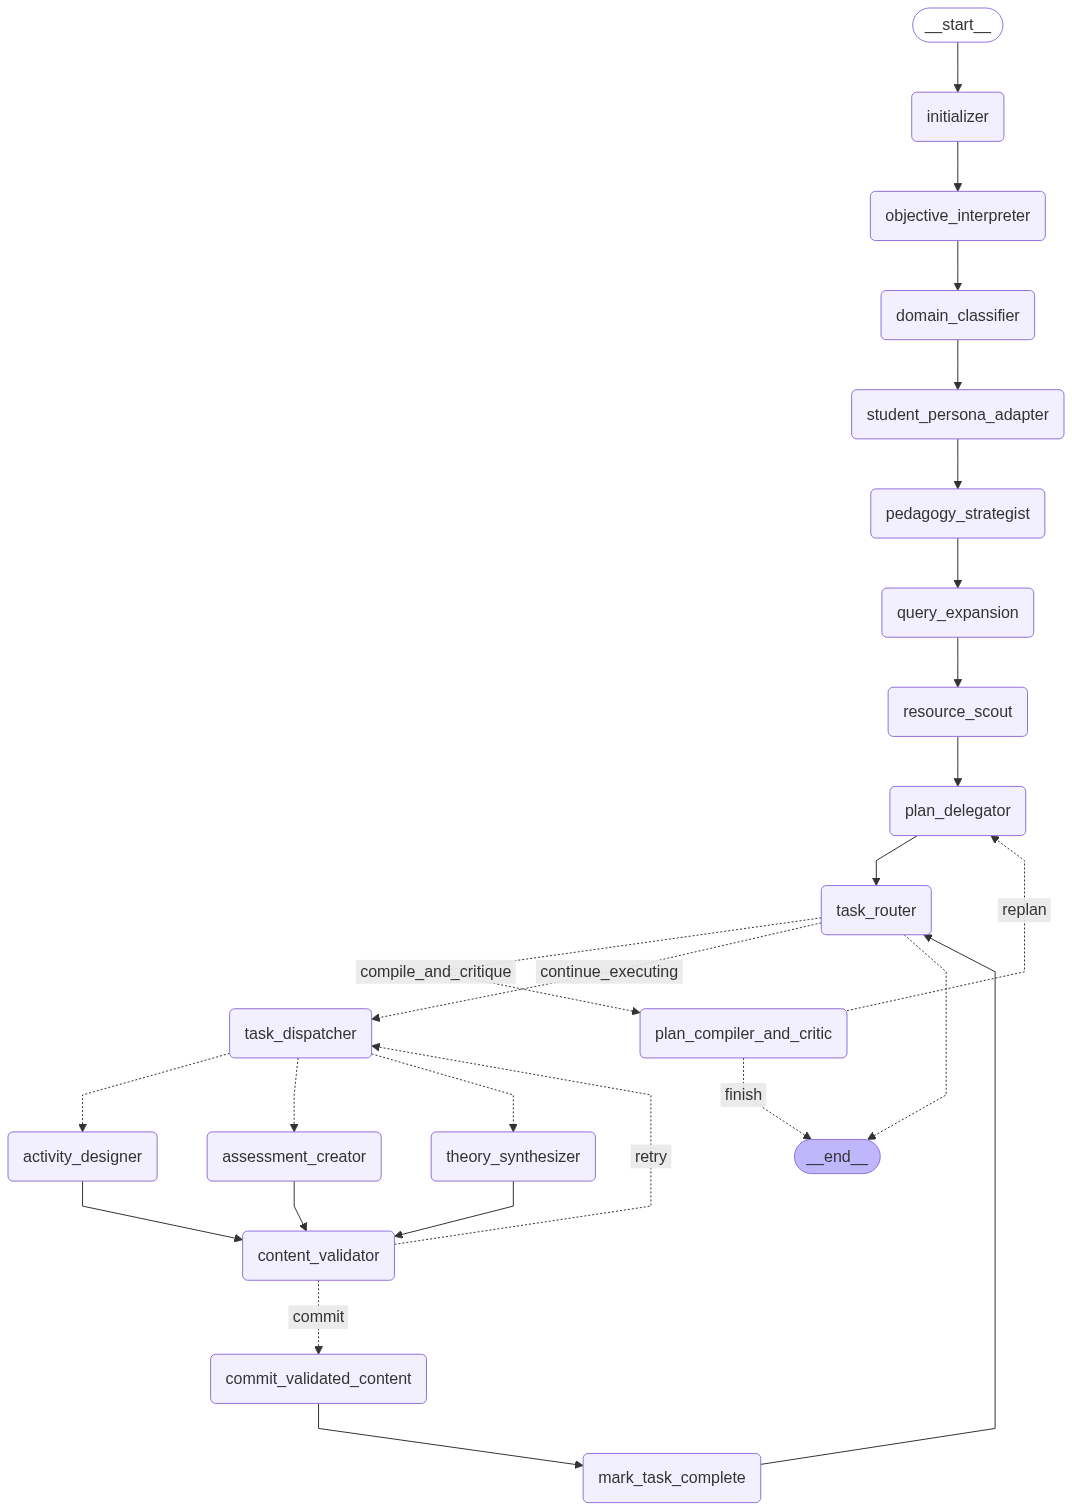

In [4]:
# ==============================================================================
# CELL 4 (Phiên bản 7.0.1 - Sửa lỗi Nối dây Graph)
# ==============================================================================
from typing import Literal, Dict, Any

# --- CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI (KHÔNG ĐỔI) ---

def mark_task_complete(state: "TeacherStateV4") -> Dict[str, Any]:
    """
    Node tiện ích: Đánh dấu nhiệm vụ hiện tại là 'completed' và xóa current_task_id
    để chuẩn bị cho vòng lặp tiếp theo của router.
    """
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: 
        return {}
    
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
            
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV4") -> Dict[str, Any]:
    """
    Node tiện ích: Kiểm tra xem còn nhiệm vụ nào trong danh sách ở trạng thái 'pending' không.
    """
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    """
    Agent điều phối: Phân loại nhiệm vụ hiện tại và quyết định agent chuyên môn nào sẽ thực hiện.
    """
    print_step("`Agent: Task Dispatcher` (v7.0) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)

    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Nhiệm vụ:** Phân loại mô tả nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.

    **QUY TẮC PHÂN LOẠI:**
    - Nếu nhiệm vụ liên quan đến việc giảng giải, trình bày, giới thiệu, ôn tập lý thuyết, định nghĩa, định lý, khởi động, tổng kết -> **'theory_synthesizer'**.
    - Nếu nhiệm vụ yêu cầu học sinh thực hành, làm bài tập, luyện tập, thảo luận, làm việc nhóm, vận dụng kiến thức -> **'activity_designer'**.
    - Nếu nhiệm vụ là kiểm tra, đánh giá, cho bài tập về nhà, ra một bài toán khó để tổng kết, một bài toán chứng minh phức tạp, vận dụng cao -> **'assessment_creator'**.

    **NHIỆM VỤ CẦN PHÂN LOẠI:** "{task_description}"

    **YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`.
    """
    structured_llm = llm.with_structured_output(TaskClassification)

    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher khi phân loại: {e}. Giao nhiệm vụ cho agent mặc định 'activity_designer'.")
        next_agent = "activity_designer"

    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

# --- CÁC HÀM ĐIỀU HƯỚNG ---
def route_after_validation(state: "TeacherStateV4") -> Literal["commit", "retry"]:
    """Quyết định commit nội dung hay yêu cầu làm lại dựa trên phản hồi của chuyên gia."""
    # Sửa lỗi: Nếu validation_feedback là một chuỗi rỗng hoặc có nội dung, nghĩa là có lỗi.
    if state.get("validation_feedback"):
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để thử lại.")
        return "retry"
    else:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"

def route_after_router(state: "TeacherStateV4") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: return "compile_and_critique"
    else: return "continue_executing"

def route_after_compilation(state: "TeacherStateV4") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

# --- XÂY DỰNG GRAPH PHIÊN BẢN 7.0.1 ---
workflow = StateGraph(TeacherStateV4)

# 1. Thêm tất cả các node vào graph
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("student_persona_adapter", student_persona_agent)
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("plan_compiler_and_critic", plan_compiler_and_critic_agent)

# 2. <<< ĐÂY LÀ CHUỖI KẾT NỐI ĐÃ SỬA LỖI >>>
# Xây dựng một "đường ống" (pipeline) tuần tự cho các bước setup ban đầu.
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "student_persona_adapter") # Phải chạy bước này
workflow.add_edge("student_persona_adapter", "pedagogy_strategist") # Rồi mới đến bước này
workflow.add_edge("pedagogy_strategist", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")
# =======================================================

# 3. Kết nối vòng lặp thực thi nhiệm vụ chính
workflow.add_conditional_edges(
    "task_router",
    route_after_router,
    {"continue_executing": "task_dispatcher", "compile_and_critique": "plan_compiler_and_critic"}
)
workflow.add_conditional_edges(
    "task_dispatcher",
    lambda state: state["next_agent"],
    {"activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer"}
)

# 4. Xây dựng vòng lặp PHẢN BIỆN VI MÔ (Micro-loop)
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")
workflow.add_conditional_edges(
    "content_validator",
    route_after_validation,
    {
        "commit": "commit_validated_content",
        # Sửa lỗi: Nếu retry, phải quay lại chính agent đã làm sai, không phải dispatcher
        # Logic này sẽ được đơn giản hóa bằng cách quay lại dispatcher, nhưng dispatcher sẽ cần biết nhiệm vụ trước đó
        # Để đơn giản, ta vẫn quay lại dispatcher
        "retry": "task_dispatcher"
    }
)
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")

# 5. Kết nối vòng lặp tự sửa lỗi LỚN (Macro-loop)
workflow.add_conditional_edges(
    "plan_compiler_and_critic",
    route_after_compilation,
    {"replan": "plan_delegator", "finish": END}
)

# 6. Biên dịch Graph
app = workflow.compile()
print("✅ Graph 7.0.1 (Sửa lỗi Nối dây) đã được biên dịch thành công.")

# 7. Vẽ biểu đồ để kiểm tra trực quan
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}")

In [5]:
# ==============================================================================
# CELL 5 (Phiên bản 7.0): CHẠY THỬ NGHIỆM CUỘC CẢI CÁCH
# ==============================================================================

async def run_reformation(user_request: str):
    # Kiểm tra xem các biến cần thiết đã được khởi tạo chưa
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.")
        return

    initial_state = {
        "messages": [HumanMessage(content=user_request)],
    }
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.0 (THE REFORMATION) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    # Tăng giới hạn đệ quy vì có thêm các vòng lặp vi mô, có thể cần nhiều bước hơn
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.0.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_lesson_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v7.0)[/bold green]")
            console.print(Markdown(final_state_result["final_lesson_plan"]))
        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

# === YÊU CẦU MỚI ĐỂ KIỂM TRA TÍNH NĂNG PHÂN TÍCH HỌC SINH ===
reformation_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
await run_reformation(reformation_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.0 (THE REFORMATION) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Objective Interpreter` (v7.0.1) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 3,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': '9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.0.1) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Student Persona Adapter` (v7.0.2) đang phân tích đặc điểm lớp học...

✔️ Hồ sơ lớp học đã được phân tích:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học yếu, dễ mất tập trung, cần các hoạt động tương tác cao'
}

------- Hoàn thành bước: student_persona_adapter -------

> `Agent: Pedagogy Strategist` (v7.0.1) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học theo vấn đề',
│   'rationale': 'Phương pháp này phù hợp với lớp học yếu, dễ mất tập trung và cần các hoạt động tương tác cao. Bằng cách đặt vấn đề thực tế, học sinh sẽ được kích thích và tham gia tích cực vào quá trình học tập, giúp tăng cường sự tập trung và hứng thú.',
│   'key_actions': [
│   │   'Đặt vấn đề',
│   │   'Học sinh thảo luận nhóm',
│   │   'Tìm kiếm và trình bày giải pháp',
│   │   'Thảo luận và phản hồi'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Query Expansion` (v7.0.1) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'tính chất đường tròn ngoại tiếp',
│   'đường tròn nội tiếp là gì',
│   'ứng dụng đường tròn ngoại tiếp trong toán học',
│   'so sánh đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'đường tròn ngoại tiếp và đường tròn nội tiếp trong hình học',
│   'công thức tính đường tròn ngoại tiếp',
│   'đường tròn nội tiếp của một đa giác',
│   'đường tròn ngoại tiếp của một hình thang',
│   'tìm đường tròn ngoại tiếp của một tam giác',
│   'đường tròn nội tiếp và ngoại tiếp trong giải toán'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v7.0.1) đang tìm kiếm và sàng lọc...

> Tìm thấy 55 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': '**Tóm tắt kiến thức cốt lõi về đường tròn ngoại tiếp và đường tròn nội tiếp**\n\n**Định nghĩa:**\n\n* Đường tròn ngoại tiếp của một đa giác là đường tròn đi qua tất cả các đỉnh của đa giác đó.\n* Đường tròn nội tiếp của một đa giác là đường tròn nằm trong đa giác và tiếp xúc với tất cả các cạnh của đa giác đó.\n\n**Định lý:**\n\n* Ba điểm nằm trên một đường tròn nếu và chỉ nếu chúng cùng thuộc một đường tròn.\n* Nếu một đường tròn đi qua ba điểm của một đa giác, thì đường tròn đó là đường tròn ngoại tiếp của đa giác đó.\n\n**Công thức tính độ dài cung tròn:**\n\n* Độ dài của đường tròn (O; R) là: C = 2πR\n* Độ dài của cung n° trên đường tròn (O; R) là: l = πRn/180\n\n**Nhận xét:**\n\n* Tỉ số giữa độ dài cung n° và độ dài đường tròn (cùng bán kính) đúng bằng n/360.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v7.0.1) đang lập kế hoạch thông thái...

✔️ Đã tạo 6 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Hình thành kiến thức mới: Định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'task_description': 'Học sinh thảo luận nhóm và trả lời các câu hỏi về định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Đặt vấn đề',
│   │   'task_description': 'Giáo viên đặt vấn đề thực tế về đường tròn ngoại tiếp và đường tròn nội tiếp, học sinh thảo luận nhóm và trả lời',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Luyện tập: Tính độ dài cung tròn',
│   │   'task_description': 'Học sinh thực hành tính độ dài cung tròn bằng công thức, giáo viên hỗ trợ và phản hồi',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tìm kiếm và trình bày giải pháp',
│   │   'task_description': 'Học sinh tìm kiếm và trình bày các giải pháp cho vấn đề đã đặt, giáo viên phản hồi và hướng dẫn',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Thảo luận và phản hồi',
│   │   'task_description': 'Học sinh thảo luận và phản hồi về các giải pháp đã trình bày, giáo viên tổng kết và hướng dẫn',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Đánh giá/Vận dụng cao: Bài tập thực hành',
│   │   'task_description': 'Học sinh thực hành các bài tập về đường tròn ngoại tiếp và đường tròn nội tiếp, giáo viên đánh giá và phản hồi',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Hình thành kiến thức mới: Định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.0.1) đang thực thi...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Thảo luận nhóm về định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Học sinh thảo luận nhóm và trả lời các câu hỏi về định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp.',
│   'duration_minutes': 15,
│   'activity_type': 'Thảo luận nhóm',
│   'solution_guide': 'Hướng dẫn học sinh thảo luận nhóm và trả lời các câu hỏi về định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Đặt vấn đề' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.0.1) đang thực thi...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Giáo viên đặt vấn đề thực tế về đường tròn ngoại tiếp và đường tròn nội tiếp, học sinh thảo luận nhóm và trả lời.',
│   'duration_minutes': 10,
│   'activity_type': 'Thảo luận nhóm',
│   'solution_guide': 'Giáo viên hướng dẫn học sinh thảo luận và trả lời các câu hỏi liên quan đến đường tròn ngoại tiếp và đường tròn nội tiếp.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập: Tính độ dài cung tròn' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.0.1) đang thực thi...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Tính độ dài cung tròn bằng công thức',
│   'description': 'Học sinh thực hành tính độ dài cung tròn bằng công thức, giáo viên hỗ trợ và phản hồi.',
│   'duration_minutes': 20,
│   'activity_type': 'Luyện tập cặp đôi',
│   'solution_guide': 'Giáo viên hướng dẫn học sinh thực hành tính độ dài cung tròn bằng công thức, sau đó cho học sinh thực hành và phản hồi kết quả.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tìm kiếm và trình bày giải pháp' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.0.1) đang thực thi...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Giải phương trình bậc nhất',
│   'description': 'Học sinh sẽ được hướng dẫn giải phương trình bậc nhất và tìm kiếm các giải pháp cho vấn đề đã đặt.',
│   'duration_minutes': 20,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Hướng dẫn giải: 1) Đọc kỹ đề bài, 2) Xác định phương trình bậc nhất, 3) Áp dụng công thức giải phương trình bậc nhất, 4) Kiểm tra kết quả.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Thảo luận và phản hồi' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.0.1) đang thực thi...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Thảo luận và phản hồi về các giải pháp đã trình bày',
│   'description': 'Học sinh thảo luận và phản hồi về các giải pháp đã trình bày, giáo viên tổng kết và hướng dẫn.',
│   'duration_minutes': 15,
│   'activity_type': 'Thảo luận nhóm',
│   'solution_guide': 'Giáo viên cần hướng dẫn học sinh thảo luận và phản hồi về các giải pháp đã trình bày, sau đó tổng kết và hướng dẫn học sinh.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Đánh giá/Vận dụng cao: Bài tập thực hành' (ID: 5)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v7.0.1) đang thực thi...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Hoạt động thực hành đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Học sinh thực hành các bài tập về đường tròn ngoại tiếp và đường tròn nội tiếp, giáo viên đánh giá và phản hồi.',
│   'duration_minutes': 10,
│   'activity_type': 'Luyện tập cặp đôi',
│   'solution_guide': 'Giáo viên hướng dẫn học sinh thực hành các bài tập, sau đó đánh giá và phản hồi kết quả.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Domain Expert Critic` (v7.0.1) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Plan Compiler & Critic` (v7.0.1) đang tổng hợp và đánh giá...

> CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: plan_compiler_and_critic -------

🏁 KẾT THÚC QUY TRÌNH V7.0.

📝 GIÁO ÁN HOÀN CHỈNH (v7.0)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                          GIÁO ÁN BÀI DẠY: Đường tròn ngoại tiếp và đường tròn nội tiếp                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                I. THÔNG TIN CHUNG                                                 

 • Môn học: Toán học                                                                                               
 • Lớp: 9                                                                                                          
 • Thời lượng dự kiến: 90 phút / 90 phút                                                                           
 • Phương pháp sư phạm chủ đạo: Dạy học theo vấn đề                                                                
 • Đặc điểm lớp học: Lớp học yếu, dễ mất tập trung, cần các hoạt động tương tác cao                                

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể Soạn kiến thức về Đường tròn ngoại tiếp và đường tròn nội tiếp để giải quyết các bài toán liên  
   quan.                                                                                                           
 • Rèn luyện kỹ năng tư duy logic, mô hình hóa toán học và giải quyết vấn đề.                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                   III. CHUẨN BỊ                                                   

 • Giáo viên: Bảng phụ, phấn màu, phiếu học tập (nếu có).                                                          
 • Học sinh: Sách giáo khoa, vở ghi, dụng cụ học tập.                                                              
 • Nguồn tài liệu tham khảo: Sách giáo khoa (từ RAG - đã sàng lọc)                                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                              IV. TIẾN TRÌNH BÀI DẠY                                               

         Hoạt động 1: Thảo luận nhóm về định nghĩa đường tròn ngoại tiếp và đường tròn nội tiếp (15 phút)          

 • Loại hình: Thảo luận nhóm                                                                                       
 • Mô tả/Nhiệm vụ: Học sinh thảo luận nhóm và trả lời các câu hỏi về định nghĩa đường tròn ngoại tiếp và đường tròn
   nội tiếp.                                                                                                       
 • Gợi ý đáp án/Hướng dẫn giải: Hướng dẫn học sinh thảo luận nhóm và trả lời các câu hỏi về định nghĩa đường tròn  
   ngoại tiếp và đường tròn nội tiếp.                                                                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                        Hoạt động 2: Đường tròn ngoại tiếp và đường tròn nội tiếp (10 phút)                        

 • Loại hình: Thảo luận nhóm                                                                                       
 • Mô tả/Nhiệm vụ: Giáo viên đặt vấn đề thực tế về đường tròn ngoại tiếp và đường tròn nội tiếp, học sinh thảo luận
   nhóm và trả lời.                                                                                                
 • Gợi ý đáp án/Hướng dẫn giải: Giáo viên hướng dẫn học sinh thảo luận và trả lời các câu hỏi liên quan đến đường  
   tròn ngoại tiếp và đường tròn nội tiếp